In [1]:
import sys
sys.path.append("../")


import os
%matplotlib inline
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf
from patsy import dmatrices
from openpyxl import load_workbook

from linearmodels import PanelOLS

/Users/kylieleblancKylie/anaconda/envs/spacy/lib/python3.7/site-packages/linearmodels/panel/data.py:10: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import (Categorical, DataFrame, Index, MultiIndex, Panel, Series,


In [2]:
def coef_with_stars(coef, pvalue):
    coef = round(coef, 2)
    if pvalue >.05:
        coef = str(coef)
    if pvalue <= .05:
        coef = str(coef) + '*'
    if pvalue <= .01:
        coef = coef + '*'
    if pvalue <= .001:
        coef = coef + '*'
    return(coef)
test = coef_with_stars(9.1568, 0.8523)
test

'9.16'

In [3]:
def format_se(se):
    if se < .005:
        se = '(0.00)'
    else:
        se = '(' + str(round(se, 2)) + ')'
    return se
test = format_se(.0053)
test

'(0.01)'

In [4]:
data_path = '/Users/kylieleblancKylie/domino/dofis/data/'
table_path = '/Users/kylieleblancKylie/domino/dofis/results/Who Needs Rules/'
data = pd.read_csv(os.path.join(data_path, 'clean', 'gdid_subject.csv'),
                  sep=",", low_memory= False)
#load(data)
print(data[data.doi == True].district.nunique())
data = data[data.doi == True]

data['doi_year'] = np.where((data.doi_year == 2015), np.nan, data.doi_year) #drop first implementer (one district)
# drop english II, us history, 8th grade science
data = data[(data.test != 'eng2_avescore') & (data.test != 'us_avescore') & (data.test != 's_8th_avescore')]

data.sample(5)

822


,Unnamed: 0,campus,year,test,score,score_std,campname,campischarter,district,distname,...,middle_math,middle_reading,middle_science,algebra,biology,eng1,math,reading,avescores,treatpost
395402,395402,220904105,2018,r_5th_avescore,1532.0,-0.361641,DAN POWELL INT,N,220904,EVERMAN ISD,...,NaN,NaN,NaN,NaN,NaN,NaN,-0.366508,-0.352020,-0.359264,True
217179,217179,43910142,2013,m_5th_avescore,1672.0,1.165204,BOGGESS EL,N,43910,PLANO ISD,...,NaN,NaN,NaN,NaN,NaN,NaN,1.660556,1.476256,1.568406,False
80285,80285,145906041,2015,m_7th_avescore,1676.0,0.603437,NORMANGEE MIDDLE,N,145906,NORMANGEE ISD,...,0.377545,0.427991,0.174332,0.499004,NaN,NaN,0.377545,0.427991,0.386243,False
51856,51856,101910042,2014,alg_avescore,4614.0,1.367923,NORTH SHORE MIDDLE,N,101910,GALENA PARK ISD,...,0.663494,-0.117588,0.782052,1.485867,NaN,NaN,0.663494,-0.117588,0.559955,False
401564,401564,249905042,2016,r_6th_avescore,1619.0,0.565909,MCCARROLL MIDDLE 6TH GRADE,N,249905,DECATUR ISD,...,0.625783,0.563693,NaN,NaN,NaN,NaN,0.625783,0.563693,0.594738,False


# Prepare data for specifications

In [5]:
# Create year-test fixed effects
data['test_by_year'] = data['test'] + data['year'].map(str)

# Phase in and pre-trends
data['yearpost'] = np.where(data.year > data.doi_year, data.year - data.doi_year, 0)
data['yearpre'] = np.where(data.year <= data.doi_year, data.year - data.doi_year, 0)

# Non-parametric fixed effects for years pre and post
data['pre5'] = np.where(data.yearpre <= -5, 1, 0)
data['pre4'] = np.where(data.yearpre == -4, 1, 0)
data['pre3'] = np.where(data.yearpre == -3, 1, 0)
data['pre2'] = np.where(data.yearpre == -2, 1, 0)
data['pre1'] = np.where(data.yearpre == -1, 1, 0)
data['pre0'] = np.where(data.yearpre == 0, 1, 0)
data['post1'] = np.where(data.yearpost == 1, 1, 0)
data['post2'] = np.where(data.yearpost == 2, 1, 0)
data['post3'] = np.where(data.yearpost == 3, 1, 0)

# Create HTE Variables

In [18]:
data_pre = data.loc[data.pre1 == 1]
data_pre['avescores_pre'] = data_pre.groupby('campus')['score_std'].transform('mean')
data_pre = data_pre.drop_duplicates(subset = 'campus')
data_pre = data_pre.rename(columns = {'students_hisp': 'students_hisp_pre',
                                     'teachers_turnover_ratio_d': 'teacher_turnover_pre',
                                     'students_ell': 'students_ell_pre',
                                     'students_sped': 'students_sped_pre',
                                     'score_std': 'score_std_pre',
                                    'students_num': 'students_num_pre'})
for var in ['students_hisp_pre', 'students_ell_pre', 'students_num_pre', 'teacher_turnover_pre', 'avescores_pre']:
    for p in [.25, .5, .75, 1]:
        num = str(int(p * 100))
        newvar = var + num
        if p == .25:
            data_pre[newvar] = np.where(data_pre[var] <= data_pre[var].quantile(p), 1, 0)
        if p > .25:
            lp = p - .25
            data_pre[newvar] = np.where(((data_pre[var] > data_pre[var].quantile(lp)) &
                                         (data_pre[var] <= data_pre[var].quantile(p))), 1, 0)

variables = ['campus']
variables = variables + (list(data_pre.filter(regex = ("_pre"))))
data_pre = data_pre[variables]
data_pre.sample(5)

/Users/kylieleblancKylie/anaconda/envs/spacy/lib/python3.7/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app


,campus,score_std_pre,students_num_pre,teacher_turnover_pre,students_hisp_pre,students_ell_pre,students_sped_pre,avescores_pre,students_hisp_pre25,students_hisp_pre50,...,students_num_pre75,students_num_pre100,teacher_turnover_pre25,teacher_turnover_pre50,teacher_turnover_pre75,teacher_turnover_pre100,avescores_pre25,avescores_pre50,avescores_pre75,avescores_pre100
111168,240903003,0.190375,2752,6.7,0.971294,0.091570,0.045785,0.164169,0,0,...,0,1,1,0,0,0,0,0,1,0
301506,114901113,-1.151045,442,25.5,0.665158,0.033937,0.038462,-1.174618,0,0,...,0,0,0,0,0,1,1,0,0,0
306681,220905151,-0.089629,487,14.0,0.864476,0.626283,0.055441,-0.286330,0,0,...,0,0,0,1,0,0,0,1,0,0
136450,246913047,2.049910,734,13.2,0.190736,0.028610,0.074932,1.674340,1,0,...,1,0,0,1,0,0,0,0,0,1
94306,57905354,0.780329,763,21.6,0.427261,0.292267,0.102228,-0.899990,0,0,...,1,0,0,0,0,1,1,0,0,0


Text(0.04,0.02,'The four horizontal lines represent the 25th, 50th, 75th and 100th percentile.')

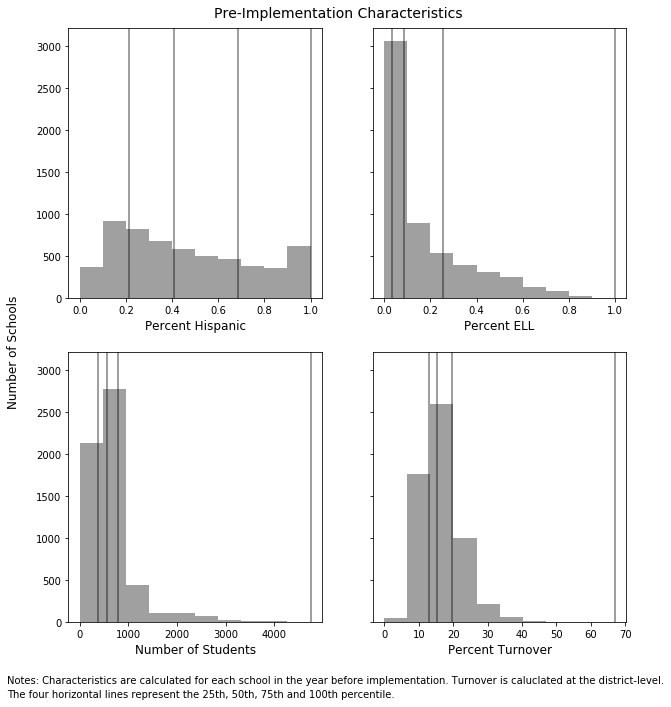

In [19]:
fig, ax = plt.subplots(2,2, sharey=True, sharex = False, figsize=(10, 10))

ax1 = ax[0,0]
ax2 = ax[0,1]
ax3 = ax[1,0]
ax4 = ax[1,1]


bins = 10

ax1.hist(data_pre.students_hisp_pre, bins, facecolor='gray', alpha=0.75)
ax1.set_xlabel('Percent Hispanic', fontsize = 12)
for p in [.25, .5, .75, 1]:
    ax1.axvline(data_pre.students_hisp_pre.quantile(p), color = 'black', alpha = 0.5 )


ax2.hist(data_pre.students_ell_pre, bins, facecolor='gray', alpha=0.75)
ax2.set_xlabel('Percent ELL', fontsize = 12)
for p in [.25, .5, .75, 1]:
    ax2.axvline(data_pre.students_ell_pre.quantile(p), color = 'black', alpha = 0.5 )

ax3.hist(data_pre.students_num_pre,  bins, facecolor='gray', alpha=0.75)
ax3.set_xlabel('Number of Students', fontsize = 12)
for p in [.25, .5, .75, 1]:
    ax3.axvline(data_pre.students_num_pre.quantile(p), color = 'black', alpha = 0.5 )


ax4.hist(data_pre.teacher_turnover_pre,  bins, facecolor='gray', alpha=0.75)
ax4.set_xlabel('Percent Turnover', fontsize = 12)
for p in [.25, .5, .75, 1]:
    ax4.axvline(data_pre.teacher_turnover_pre.quantile(p), color = 'black', alpha = 0.5 )


fig.text(0.04, 0.5, 'Number of Schools', va='center', rotation='vertical', fontsize = 12)
fig.suptitle('Pre-Implementation Characteristics', fontsize = 14)
fig.subplots_adjust(top=0.95)
fig.savefig(table_path + 'Pre-Implementation Characteristics.png')

fig.text(0.04, 0.04, 'Notes: Characteristics are calculated for each school in the year before implementation.'
        ' Turnover is caluclated at the district-level.')
fig.text(0.04, 0.02,'The four horizontal lines represent the 25th, 50th, 75th and 100th percentile.')

In [20]:
data = data.reset_index().set_index(['campus', 'test'])
data_pre = data_pre.reset_index().set_index(['campus'])
data.head()

index  Unnamed: 0  year   score  score_std  \
campus    test                                                         
109901001 alg_avescore       17          17  2012  4069.0   0.081824   
          bio_avescore       18          18  2012  3852.0  -0.565197   
          eng1_avescore      19          19  2012  4076.0   0.603661   
          m_3rd_avescore     20          20  2012  1463.0   0.328504   
          m_4th_avescore     21          21  2012  1494.0  -0.521858   

                               campname campischarter  district    distname  \
campus    test                                                                
109901001 alg_avescore    ABBOTT SCHOOL             N    109901  ABBOTT ISD   
          bio_avescore    ABBOTT SCHOOL             N    109901  ABBOTT ISD   
          eng1_avescore   ABBOTT SCHOOL             N    109901  ABBOTT ISD   
          m_3rd_avescore  ABBOTT SCHOOL             N    109901  ABBOTT ISD   
          m_4th_avescore  ABBOTT SCHOOL             N    109901  ABBOTT ISD   

                         distischarter  ... yearpre pre5 pre4 pre3 pre2 pre1  \
campus    test                          ...                                    
109901001 alg_avescore               N  ...    -6.0    1    0    0    0    0   
          bio_avescore               N  ...    -6.0    1    0    0    0    0   
          eng1_avescore              N  ...    -6.0    1    0    0    0    0   
          m_3rd_avescore             N  ...    -6.0    1    0    0    0    0   
          m_4th_avescore             N  ...    -6.0    1    0    0    0    0   

                          pre0  post1  post2  post3  
campus    test                                       
109901001 alg_avescore       0      0      0      0  
          bio_avescore       0      0      0      0  
          eng1_avescore      0      0      0      0  
          m_3rd_avescore     0      0      0      0  
          m_4th_avescore     0      0      0      0  

[5 rows x 172 columns]

In [21]:
data_hte = data.merge(data_pre, left_index = True, right_index = True, how = 'left')
data_hte['majority_hisp_pre'] = np.where(data_hte.students_hisp_pre > .6, 1, 0)
data_hte['high_turnover'] = np.where(data_hte.teacher_turnover_pre > 20, 1, 0)
data_hte.head(5)

index_x  Unnamed: 0  year   score  score_std  \
campus    test                                                           
109901001 alg_avescore         17          17  2012  4069.0   0.081824   
          bio_avescore         18          18  2012  3852.0  -0.565197   
          eng1_avescore        19          19  2012  4076.0   0.603661   
          m_3rd_avescore       20          20  2012  1463.0   0.328504   
          m_4th_avescore       21          21  2012  1494.0  -0.521858   

                               campname campischarter  district    distname  \
campus    test                                                                
109901001 alg_avescore    ABBOTT SCHOOL             N    109901  ABBOTT ISD   
          bio_avescore    ABBOTT SCHOOL             N    109901  ABBOTT ISD   
          eng1_avescore   ABBOTT SCHOOL             N    109901  ABBOTT ISD   
          m_3rd_avescore  ABBOTT SCHOOL             N    109901  ABBOTT ISD   
          m_4th_avescore  ABBOTT SCHOOL             N    109901  ABBOTT ISD   

                         distischarter  ... teacher_turnover_pre25  \
campus    test                          ...                          
109901001 alg_avescore               N  ...                    0.0   
          bio_avescore               N  ...                    0.0   
          eng1_avescore              N  ...                    0.0   
          m_3rd_avescore             N  ...                    0.0   
          m_4th_avescore             N  ...                    0.0   

                         teacher_turnover_pre50 teacher_turnover_pre75  \
campus    test                                                           
109901001 alg_avescore                      0.0                    1.0   
          bio_avescore                      0.0                    1.0   
          eng1_avescore                     0.0                    1.0   
          m_3rd_avescore                    0.0                    1.0   
          m_4th_avescore                    0.0                    1.0   

                         teacher_turnover_pre100 avescores_pre25  \
campus    test                                                     
109901001 alg_avescore                       0.0             0.0   
          bio_avescore                       0.0             0.0   
          eng1_avescore                      0.0             0.0   
          m_3rd_avescore                     0.0             0.0   
          m_4th_avescore                     0.0             0.0   

                         avescores_pre50  avescores_pre75  avescores_pre100  \
campus    test                                                                
109901001 alg_avescore               0.0              0.0               1.0   
          bio_avescore               0.0              0.0               1.0   
          eng1_avescore              0.0              0.0               1.0   
          m_3rd_avescore             0.0              0.0               1.0   
          m_4th_avescore             0.0              0.0               1.0   

                          majority_hisp_pre  high_turnover  
campus    test                                              
109901001 alg_avescore                    0              0  
          bio_avescore                    0              0  
          eng1_avescore                   0              0  
          m_3rd_avescore                  0              0  
          m_4th_avescore                  0              0  

[5 rows x 202 columns]

In [22]:
data_pre = data.loc[data.year == 2016]
data_pre.loc[:, 'rural_pre'] = np.where(data_pre.type_description == "RURAL", 1, 0)
data_pre.loc[:,'urban_pre'] = np.where(data_pre.type_description == "URBAN", 1, 0)
data_pre = data_pre[['rural_pre', 'urban_pre']]
data_hte = data_hte.join(data_pre, how = 'left')
data_hte.sample(5)

/Users/kylieleblancKylie/anaconda/envs/spacy/lib/python3.7/site-packages/pandas/core/indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/Users/kylieleblancKylie/anaconda/envs/spacy/lib/python3.7/site-packages/pandas/core/indexing.py:480: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


,,index_x,Unnamed: 0,year,score,score_std,campname,campischarter,district,distname,distischarter,...,teacher_turnover_pre75,teacher_turnover_pre100,avescores_pre25,avescores_pre50,avescores_pre75,avescores_pre100,majority_hisp_pre,high_turnover,rural_pre,urban_pre
campus,test,,,,,,,,,,,,,,,,,,,,,
104901001,alg_avescore,30846,30846,2013,3573.0,-1.088645,HASKELL H S,N,104901,HASKELL ISD,N,...,0.0,0.0,0.0,0.0,1.0,0.0,0,0,1.0,0.0
101903110,r_4th_avescore,272648,272648,2015,1510.0,0.063132,PETROSKY EL,N,101903,ALIEF ISD,N,...,0.0,0.0,0.0,0.0,1.0,0.0,0,0,0.0,0.0
15916106,m_4th_avescore,201319,201319,2012,1594.0,1.020061,CRESTVIEW EL,N,15916,JUDSON ISD,N,...,1.0,0.0,0.0,0.0,0.0,1.0,1,0,0.0,0.0
175911042,m_8th_avescore,354448,354448,2018,1689.0,0.656431,RICE INTERMEDIATE/MIDDLE SCHOOL,N,175911,RICE ISD (175911),N,...,0.0,1.0,0.0,1.0,0.0,0.0,1,1,1.0,0.0
71901045,r_8th_avescore,170223,170223,2019,1657.0,-0.233486,RICARDO ESTRADA MIDDLE,N,71901,CLINT ISD,N,...,0.0,0.0,0.0,1.0,0.0,0.0,1,0,0.0,0.0


In [23]:
#convert year to datetime
data_hte = data_hte.reset_index()
data_hte['year'] = pd.to_datetime(data_hte['year'], format='%Y')
#add column year to index
data_hte = data_hte.set_index(['year', 'campus'])
#swap indexes
data_hte.index = data_hte.index.swaplevel(0,1)
data_hte[['district', 'doi_year','treatpost', 'students_hisp_pre',]].sample(5)

,,district,doi_year,treatpost,students_hisp_pre
campus,year,,,,
57916108,2016-01-01,57916,2017.0,False,0.082380
152901067,2014-01-01,152901,2017.0,False,0.593301
3903121,2017-01-01,3903,2017.0,False,0.158940
152901162,2015-01-01,152901,2017.0,False,0.583138
57903125,2015-01-01,57903,2018.0,False,0.465537


# Hispanic

In [24]:
# Get table ready
file = table_path + 'table4_gdid_and_event_hte.xlsx'
wb = load_workbook(file)
ws = wb.active

In [26]:
formula_vars = ''
for p in [25, 50, 75, 100]:
    newvar = 'treatpost_hisp' + str(p)
    var = 'students_hisp_pre' + str(p)
    data_hte[newvar] = data_hte['treatpost'] * data_hte[var]


test = pd.Categorical(data_hte.test)
mod = PanelOLS.from_formula('score_std ~ + 1 + treatpost + students_hisp + students_num + C(test_by_year) + EntityEffects' 
     + '  + treatpost_hisp50 + treatpost_hisp75 + treatpost_hisp100', data_hte)
res = mod.fit(cov_type='clustered', cluster_entity=True)
print(res)

/Users/kylieleblancKylie/anaconda/envs/spacy/lib/python3.7/site-packages/linearmodels/utility.py:478: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  warnings.warn(missing_value_warning_msg, MissingValueWarning)


                          PanelOLS Estimation Summary                           
Dep. Variable:              score_std   R-squared:                        0.2208
Estimator:                   PanelOLS   R-squared (Between):             -0.2121
No. Observations:              253223   R-squared (Within):               0.2208
Date:                Fri, Dec 20 2019   R-squared (Overall):              0.0297
Time:                        11:30:57   Log-likelihood                -1.875e+05
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      560.84
Entities:                        5707   P-value                           0.0000
Avg Obs:                       44.371   Distribution:              F(125,247391)
Min Obs:                       1.0000                                           
Max Obs:                       120.00   F-statistic (robust):             294.02
                            

In [28]:
formula_vars = ''
for p in [25, 50, 75, 100]:
    newvar = 'treatpost_ell' + str(p)
    var = 'students_ell_pre' + str(p)
    data_hte[newvar] = data_hte['treatpost'] * data_hte[var]


test = pd.Categorical(data_hte.test)
mod = PanelOLS.from_formula('score_std ~ + 1 + treatpost + students_hisp + students_num + C(test_by_year) + EntityEffects' 
     + '  + treatpost_ell50 + treatpost_ell75 + treatpost_ell100', data_hte)
res = mod.fit(cov_type='clustered', cluster_entity=True)
print(res)

/Users/kylieleblancKylie/anaconda/envs/spacy/lib/python3.7/site-packages/linearmodels/utility.py:478: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  warnings.warn(missing_value_warning_msg, MissingValueWarning)


                          PanelOLS Estimation Summary                           
Dep. Variable:              score_std   R-squared:                        0.2204
Estimator:                   PanelOLS   R-squared (Between):             -0.2067
No. Observations:              253223   R-squared (Within):               0.2204
Date:                Fri, Dec 20 2019   R-squared (Overall):              0.0324
Time:                        11:33:09   Log-likelihood                -1.875e+05
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      559.67
Entities:                        5707   P-value                           0.0000
Avg Obs:                       44.371   Distribution:              F(125,247391)
Min Obs:                       1.0000                                           
Max Obs:                       120.00   F-statistic (robust):             293.78
                            

In [33]:
mod = PanelOLS.from_formula('score_std ~ + 1 + treatpost + yearpost + yearpre + students_num + C(test_by_year) + EntityEffects', data_hte[data_hte.treatpost_ell100 == 1])
res = mod.fit(cov_type='clustered', cluster_entity=True)

ValueError: exog does not have full column rank.